In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
# Global Constants
GENERATIONS = 500
ROWS = COLS = 101
ORIGIN = (COLS // 2, ROWS // 2)
PHI = 1000
CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]), 
                         (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1), 
                         (ORIGIN[0], ORIGIN[1] + 1)]

K1, K2, K3, K4 = 0.74, 0.2, 0.4, 0.4
RHO = 3.85
TAU = 7

In [3]:
def initialize_grid():
    M = np.full((ROWS, COLS), 'N')
    for pos in CANCER_INIT_POSITIONS:
        M[pos] = 'C'
    return M

def sum_cell_type(M, cell_type):
    """ Count number of a specific type of cell in the grid. """
    return np.sum(M == cell_type)

def calculate_n_prime(M):
    c = sum_cell_type(M, 'C')
    e = sum_cell_type(M, 'E')
    d = sum_cell_type(M, 'D')
    n_prime = c + e + d
    return n_prime

def origin_distance(M):
    """ Calculate grid distance from origin. """
    n_prime = calculate_n_prime(M)
    R = 0
    for i in range(ROWS-1):
        for j in range(COLS-1):
            if M[i, j] == 'C':
                R += math.sqrt((i - ORIGIN[0])**2 + (j - ORIGIN[1])**2)
    R = R / n_prime if n_prime else 0
    return R

def mitosis_probability(k, n, p, time_delay, generation, history):
    """ Calculate probability of cell mitosis, considering a time delay if specified. """
    delayed_gen = generation - time_delay
    if delayed_gen in history:
        n_delayed = history[delayed_gen]['Nc']
        return k * (1 - n_delayed / p)
    else:
        # If the generation is too early to have a delay effect, use the non-delayed value
        return k * (1 - n / p)

def density_development(M):
    """ Calculate density development of tumor. """
    n_prime = calculate_n_prime(M)
    R = origin_distance(M)
    return n_prime / R**2 if R else 0

def store_history(generation, M, history):
    """ Store the number of each cell type and R at the current generation. """
    Nc = sum_cell_type(M, 'C')
    Ne = sum_cell_type(M, 'E')
    Nd = sum_cell_type(M, 'D')
    R = origin_distance(M)  # Calculate radius here
    dense = (density_development(M) > RHO)
    history[generation] = {'Nc': Nc, 'Ne': Ne, 'Nd': Nd, 'R': R, "dense": dense}

def get_quadrant(r, c):
    """ Get quadrant of coordinates relative to origin. """
    if r <= ORIGIN[0] and c > ORIGIN[1]:
        return 'I'
    elif r <= ORIGIN[0] and c <= ORIGIN[1]:
        return 'II'
    elif r > ORIGIN[0] and c <= ORIGIN[1]:
        return 'III'
    else:
        return 'IV'

def mitosis(M, newM, r, c, dense):
    """ Model cell division with density development. """
    up, rt, dn, lt = (r-1, c), (r, c+1), (r+1, c), (r, c-1)
    quadrant = get_quadrant(r, c)
    dense_map = {'I': [up, rt], 'II': [lt, up], 'III': [dn, lt], 'IV': [rt, dn]}
    not_dense_map = {'I': [dn, lt], 'II': [rt, dn], 'III': [up, rt], 'IV': [lt, up]} 
    not_normal = ('E', 'D')
    map_choice = dense_map if dense else not_dense_map
    choices = map_choice[quadrant]
    
    for choice in choices:
        if newM[choice] not in not_normal:
            newM[choice] = 'C'
            break
    return newM

def simulate_tumor_growth_one_step(M, generation, time_delay, history):
    """ Simulate a single step of tumor growth, considering a time delay if specified. """
    newM = np.copy(M)
#     dense = (density_development(M) > RHO)
    # Store the current state in the history dictionary
    store_history(generation, M, history)
    dense = history[generation]['dense']
    
#     I'm not sure if I should keep these or I should comment them, I mean the codes about dense
    delayed_gen = generation - time_delay
    if delayed_gen in history:
        dense = history[delayed_gen]['dense']
    
    for r in range(1, ROWS-1):
        for c in range(1, COLS-1):
            if M[r, c] == 'C':
                # Calculate mitosis probability, considering time delay if specified
                mitosis_prob = mitosis_probability(K1, sum_cell_type(M, 'C'), PHI, time_delay, generation, history)
                if random.random() < mitosis_prob:
                    newM = mitosis(M, newM, r, c, dense)
                elif random.random() < K2:
                    newM[r, c] = 'E'
            elif M[r, c] == 'E' and random.random() < K3:
                newM[r, c] = 'D'
            elif M[r, c] == 'D' and random.random() < K4:
                newM[r, c] = 'N'
    return newM


In [4]:
def cell_type_to_number(cell_type):
    return {'N': 0, 'C': 1, 'E': 2, 'D': 3}[cell_type]

def convert_matrix(M):
    numeric_M = np.vectorize(cell_type_to_number)(M)
    return numeric_M

def simulate_tumor_growth(time_delay = 0):
    history = {}
    M = initialize_grid()
    # plt.figure(figsize=(20, 8))  # Adjust the figure size as needed
    iteration_numbers = []
    # plot_count = 0
    for g in range(GENERATIONS):
        iteration_numbers.append(g)
        M = simulate_tumor_growth_one_step(M, g, time_delay, history)
#         print (g)
        
        # if g % 20 == 0:
        #     plot_count += 1
        #     plt.subplot(1, min(5, GENERATIONS // 20), plot_count)
        #     plt.imshow(convert_matrix(M), cmap=ListedColormap(['white', 'black', 'red', 'green']))
        #     plt.title(f'Generation {g}')
        #     plt.axis('off')

        #     if plot_count == 5:
        #         plt.show()
        #         plt.figure(figsize=(20, 8))
        #         plot_count = 0

    # plt.show()
    return history


In [5]:
history_no_delay = simulate_tumor_growth(time_delay = 0)

In [6]:
# time_delay = 5
history_delay = simulate_tumor_growth(time_delay = 5)

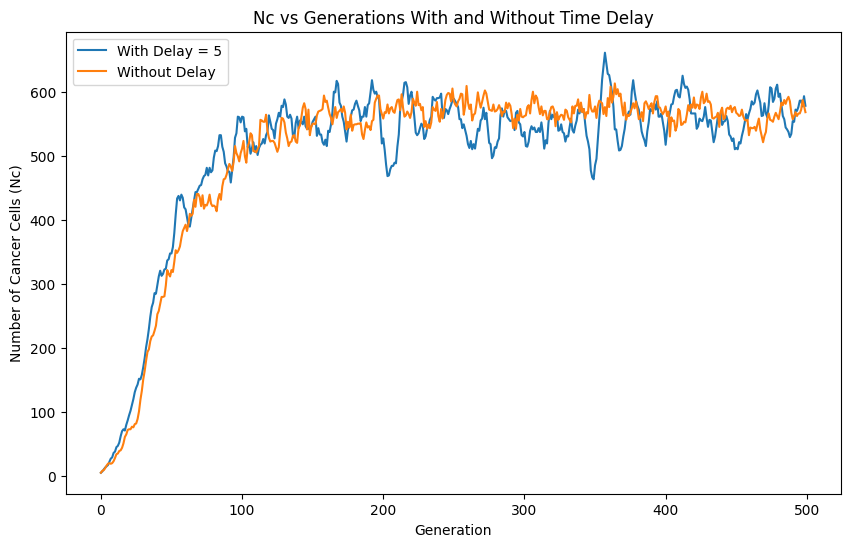

In [7]:
import matplotlib.pyplot as plt

# Assuming history_with_delay and history_without_delay are your dictionaries
# Extracting Nc values and generations
generations = list(range(GENERATIONS))
Nc_with_delay = [history_delay[g]['Nc'] for g in generations]
Nc_without_delay = [history_no_delay[g]['Nc'] for g in generations]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(generations, Nc_with_delay, label='With Delay = 5')
plt.plot(generations, Nc_without_delay, label='Without Delay')
plt.xlabel('Generation')
plt.ylabel('Number of Cancer Cells (Nc)')
plt.title('Nc vs Generations With and Without Time Delay')
plt.legend()
plt.show()
